In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import requests
import datetime, time
import pandas as pd
from pandas import DataFrame
import io
# user define package import
import sys
sys.path.append("/home/ubuntu/workspace/favis")
from msgbot.favisbot import favisbot
import util.krx_util as util

today = datetime.datetime.now().strftime('%Y%m%d')
print(today)

stock_name = '이미지스'
isu_cd, isu_srt_cd = util.getIsinCode(stock_name)
stock_code = isu_srt_cd

start = datetime.datetime(2015, 1, 1).strftime('%Y%m%d')
end = datetime.datetime(2015, 12, 31).strftime('%Y%m%d')

# STEP 01: Generate OTP
gen_otp_url = 'http://marketdata.krx.co.kr/contents/COM/GenerateOTP.jspx'
gen_otp_data = {
    'name':'fileDown',
    'filetype':'xls',
    'url':'MKD/04/0402/04020100/mkd04020100t3_02',
    'isu_srt_cd':isu_srt_cd,
    'isu_cd':isu_cd,
    'fromdate':start,
    'todate':end
}
    
r = requests.post(gen_otp_url, gen_otp_data)
code = r.text

# STEP 02: download
down_url = 'http://file.krx.co.kr/download.jspx'
down_data = {
    'code': code,
}

r = requests.post(down_url, down_data).content

filename = isu_srt_cd + ".xls"
with open(filename, 'wb') as f:
    #f.write(r.content.decode('utf-8'))
    f.write(r)

#df = pd.read_csv(io.StringIO(r.decode("utf-8")), thousands=',', parse_dates=[0], usecols=[0, '종가','거래량(주)','시가','고가','저가'])
df = pd.read_excel(filename, thousands=',', usecols=[0, '종가','거래량(주)','시가','고가','저가', '시가총액(백만)','상장주식수(주)'])

df.columns = ['Date','Adj Close','Volume','Open','High','Low', 'marcap','amount']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
 
df.set_index('Date', inplace=True)
df = df.sort_index(0, ascending=True)
df.head()

20160428


,Adj Close,Volume,Open,High,Low,marcap,amount
Date,,,,,,,
2015-01-02,4080,10720,4030,4100,3925,31290,7669128
2015-01-05,4245,32114,4050,4365,4050,32555,7669128
2015-01-06,4200,14486,4240,4245,4165,32210,7669128
2015-01-07,4225,15212,4245,4245,4140,32402,7669128
2015-01-08,4245,19116,4245,4250,4150,32555,7669128


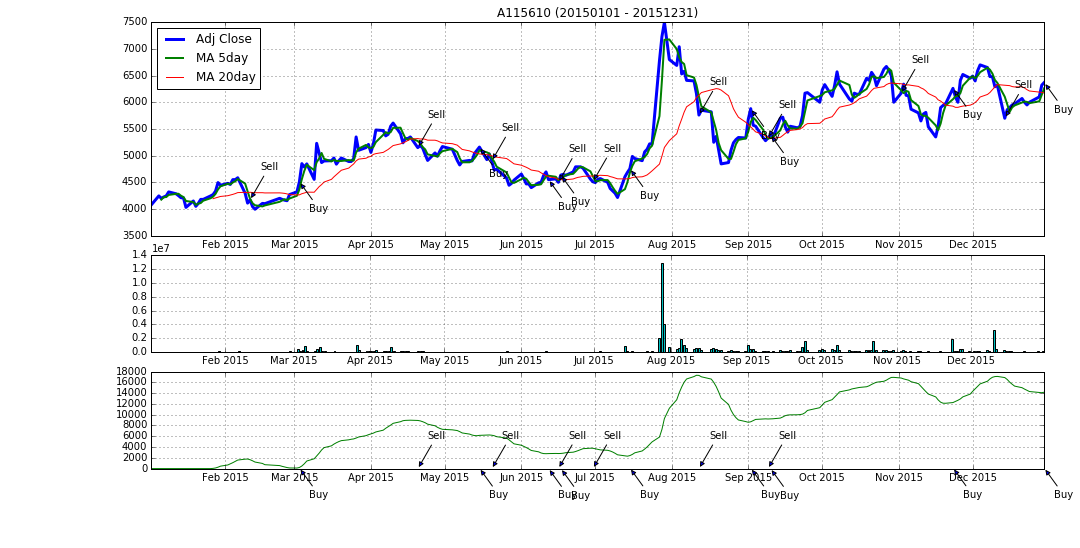

In [24]:
df = df[df.Volume > 0]

#df['MA_5'] = pd.stats.moments.rolling_mean(df['Adj Close'], 5)
df['MA_5'] = df['Adj Close'].rolling(3).mean()
df['MA_20'] = df['Adj Close'].rolling(18).mean()
df['diff'] = df['MA_5'] - df['MA_20']
df = df[['Volume', 'Adj Close', 'MA_5', 'MA_20', 'diff']]

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 8)

# price (가격)
price_chart = plt.subplot2grid((4,1), (0, 0), rowspan=2)
price_chart.plot(df.index, df['Adj Close'], label='Adj Close', lw=3)
price_chart.plot(df.index, df['MA_5'], label='MA 5day' , lw=2)
price_chart.plot(df.index, df['MA_20'], label='MA 20day', lw=1)
price_chart.grid(True)

plt.title(stock_code + " (" + str(start) + " - " + str(end) + ")")
plt.legend(loc='best')

# volume (거래량)
vol_chart = plt.subplot2grid((4,1), (2,0), rowspan=1)
vol_chart.bar(df.index, df['Volume'], color='c')
vol_chart.grid(True)

# 이동평균의 차이
signal_chart = plt.subplot2grid((4,1), (3,0), rowspan=1)
signal_chart.plot(df.index, df['diff'].fillna(0), color='g')
plt.axhline(y=0, linestyle='--', color='k')
signal_chart.grid(True)

# sell, buy annotate
prev_key = prev_val = 0

# Sell/Buy 시그널 Annotation
def annote_signal(chart, xy, text):
    textcoords='offset points'
    arrowprops=dict(arrowstyle='-|>')
    if text == 'Buy':
        xytext=(10,-30)
    elif text == 'Sell':
        xytext=(10,30)
    else:
        return
    chart.annotate(text, xy=xy, xytext=xytext, textcoords=textcoords, arrowprops=arrowprops)

for key, val in df['diff'].iteritems():
    if val == 0:
        continue
    if val * prev_val < 0 and val > prev_val:
        annote_signal(signal_chart, (key, df['diff'][key]), 'Buy')
    elif val * prev_val < 0 and val < prev_val:
        annote_signal(signal_chart, (key, df['diff'][key]), 'Sell')
    prev_key, prev_val = key, val
          
for key, val in df['diff'].iteritems():
    if val == 0:
        continue
    if val * prev_val < 0 and val > prev_val:
        annote_signal(price_chart, (key, df['Adj Close'][key]), 'Buy')
    elif val * prev_val < 0 and val < prev_val:
        annote_signal(price_chart, (key, df['Adj Close'][key]), 'Sell')
    prev_key, prev_val = key, val
    
    
plt.savefig(stock_code + '.png', bbox_inches='tight')
        

In [19]:
bot = favisbot()
bot.whisper('img',stock_code + '.png')